## Import Data

In [2]:
###import the extracted features and coded captions
import numpy as np
import h5py

LoadFlag = True
if LoadFlag:
    h5f = h5py.File('./data/features_0_40000.h5','r')
    features1 = h5f['dataset_1'][:]
    h5f.close()

    h5f = h5py.File('./data/features_40000_80000.h5','r')
    features2 = h5f['dataset_1'][:]
    h5f.close()    

    h5f = h5py.File('./data/captions_encode_8000.h5','r')
    captions_all = h5f['dataset_1'][:]
    h5f.close()
    

features_all = np.vstack((features1, features2))
print 'features: ', type(features_all), features_all.shape
print 'captions: ', type(captions_all), captions_all.shape


##import the dictionary
import os, json

vocab_path = './data/vocab.pkl'
from code.build_vocab import Vocabulary
import pickle
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
mydict = {}
mydict['idx_to_word'] = vocab.idx2word
mydict['word_to_idx'] = vocab.word2idx

print type(mydict['idx_to_word']), len(mydict['idx_to_word'])
print type(mydict['word_to_idx']), len(mydict['word_to_idx'])

features:  <type 'numpy.ndarray'> (80000, 512)
captions:  <type 'numpy.ndarray'> (400000, 17)
<type 'dict'> 8856
<type 'dict'> 8856


## Check for the order of the features and captions

loading annotations into memory...
Done (t=2.04s)
creating index...
index created!
<class 'torchvision.datasets.coco.CocoCaptions'>
('Number of samples: ', 82783)
A parking meter sitting in a parking lot next to a table with chairs.
A solar powered parking meter with table and chairs in the background.
There is a pay here machine set up outside.
a solar powered atm in front of a bunch of table and chairs
A gray and white solar powered parking machine.


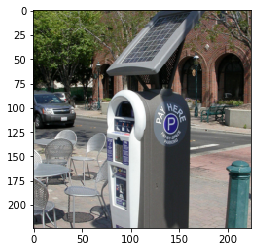

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import models

import sys
sys.path.append('/home/xuxin/work/python/data/coco-master/PythonAPI')

import torchvision.datasets as dset
import torchvision.transforms as transforms

dataDir = '/home/xuxin/work/python/data'
imageDir = '%s/train2014' % dataDir
capDir = '%s/Micro-coco/annotations/captions_train2014.json' % dataDir
transforms = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

cap = dset.CocoCaptions(root=imageDir, annFile=capDir, transform=transforms)
print type(cap)
print('Number of samples: ', len(cap))

import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img, targets):
    for i in range(len(targets)):
        print targets[i]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    plt.imshow(img)
  

rand_num = random.randint(0, len(cap))
img, targets = cap[rand_num]
imshow(img, targets)
plt.show()

In [4]:
import torchvision
from torchvision import models

class FeatureExtractor(nn.Module):
    def __init__(self, model, layer_names):
        super(FeatureExtractor, self).__init__()
        self._model = model
        self._layer_names = set(layer_names)
        
    def forward(self, x):
        outs = {}
        for name, module in self._model._modules.iteritems():
            if name in self._layer_names:
                outs[name] = x
            if isinstance(module, nn.Linear):
                x = x.view(x.size(0), -1)
            x = module(x)
        return outs

    
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
extractor = FeatureExtractor(resnet18, ['fc'])


import time
from torch.autograd import Variable

def ExtFeature(cap, startNum, BatchNum):
    imgs = []
    for i in range(BatchNum):
        print 'image Id: %d' %(startNum + i)
        img, _ = cap[startNum + i]
        imgs.append(img.unsqueeze(0))
        
    inputs = torch.cat(imgs, 0)      
    inputs = Variable(inputs)   
    features = extractor.forward(inputs)['fc'].squeeze()
    return features.data.numpy()

def wordToNum(word, word_dict):
    if word not in word_dict:
        return word_dict['<unk>']
    else:
        return word_dict[word]
            
def lineToNum(line, word_dict, length=19):
    if line[-1] == '.':
        line = line[:-1]
    line = line.lower().split()
    if len(line) > length - 3:
        line = line[:length - 3]
    result = np.ones((length))
    for i in range(1, len(line)+1):
        result[i] = wordToNum(line[i-1], word_dict)
    result[len(line)+1] = wordToNum('<end>', word_dict)
    
    for i in range(len(line)+2, length):
        result[i] = wordToNum('<pad>', word_dict)

    return result.astype('int32')

def decode_captions(captions, idx_to_word):
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in xrange(N):
        words = []
        for t in xrange(T):
            word = idx_to_word[captions[i, t]]
            if word == '<end>':
                break
            if word != '<pad>':
                words.append(word)

        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]
    return decoded

result = lineToNum("This is just a dog.", mydict['word_to_idx'], 17)
print result.shape
print result

(17,)
[   1 7065 3405 7790 7454 5532    2    0    0    0    0    0    0    0    0
    0    0]


In [5]:
# print type(features_all), features_all.shape, features_all.dtype
# print type(captions_all), captions_all.shape, captions_all.dtype
# print '='*60

# check_num = random.randint(0, len(features_all))
# check_batch = check_num/10
# batch_id = check_num % 10
# caption_id = check_num * 5
# print check_num, check_batch, batch_id, caption_id
# check_feature = ExtFeature(cap, check_batch*10, 10)

# print '='*60
# print '1:', features_all[check_num][:5]
# print '2:', check_feature[batch_id][:5]
# print '='*60

# img, targets = cap[check_num]

# for i in range(5):
#     print '1:', captions_all[caption_id+i]
#     target = targets[i]
#     print '2:', lineToNum(target, mydict['word_to_idx'], 17).astype('int32')
#     print decode_captions(captions_all[caption_id+i], mydict['idx_to_word'])

# print '='*60
# imshow(img, targets)
# plt.show()

(10, 17)
(10, 512)
[ 28872  23462 319675 114338 283512 277920 162855 179415 251390 126811]
[ 5774  4692 63935 22867 56702 55584 32571 35883 50278 25362]
check_img_id:  5774  | check_batch:  577  | batch_id:  4
image Id: 5770
image Id: 5771
image Id: 5772
image Id: 5773
image Id: 5774
image Id: 5775
image Id: 5776
image Id: 5777
image Id: 5778
image Id: 5779
features_batch: [ 0.25461531  1.33292639  0.2314842   0.76228124  1.40924037]
check_feature: [ 0.25461531  1.33292639  0.2314842   0.76228124  1.40924037]
[   1 2838  656 3405  256 8651 2572 2838 2265    2    0    0    0    0    0
    0    0]
[   1 2838  656 3405  256 8651 2572 2838 2265    2    0    0    0    0    0
    0    0]
<start> the kitchen is being cleaned by the people
A kitchen with a white refrigerator freezer next to a ice chest.
View of a kitchen being remodeled with a white refrigerator standing against a wall.
The kitchen is being cleaned by the people.
A kitchen with a refrigerator, sink and cooler bag.
A look into 

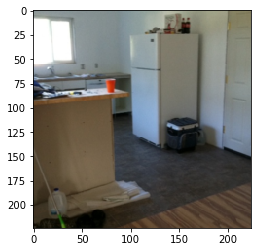

In [6]:
def coco_minibatch(batch_size, features, captions):
    size = captions.shape[0]
    mask = np.random.choice(size, batch_size)
    captions_batch = captions[mask]
    features_batch = features[mask/5]
    return captions_batch, features_batch, mask


### Check for the correspondence of the features and images and captions!
captions_batch, features_batch, mask = coco_minibatch(10, features_all, captions_all) 
print captions_batch.shape
print features_batch.shape
print mask
print mask/5
print '='*80


check_batch = (mask/5)[0]/10
batch_id = (mask/5)[0]%10
print 'check_img_id: ', (mask/5)[0], ' | check_batch: ', check_batch, ' | batch_id: ', batch_id
check_feature = ExtFeature(cap, check_batch*10, 10)
print 'features_batch:', features_batch[0][:5]
print 'check_feature:', check_feature[batch_id][:5]
print '='*80

print captions_all[mask[0]]
print captions_batch[0]
print decode_captions(captions_batch[0], mydict['idx_to_word'])
print '='*80

img, targets = cap[(mask/5)[0]]
imshow(img, targets)
plt.show()

In [7]:
def GetBatchData(features_all, captions_all, bsz = 100, isLSTM=True):
    minibatch = coco_minibatch(batch_size=bsz, features=features_all, captions=captions_all)
    captions_o, features_o, masks_o = minibatch

    ##change captions
    captions = captions_o.astype(np.int64)
    captions = torch.LongTensor(captions).t() 
    
    ##make input and target Variable:
    caption_in = Variable(captions[:-1])
    target = Variable(captions[1:]).contiguous().view(-1)
    
    ##change features to init hidden layer
    hidden_0 = features_o[np.newaxis, :]
    hidden_0 = Variable(torch.FloatTensor(hidden_0))
    
    if isLSTM:
        c_0 = hidden_0.clone()
        hidden_0 = (hidden_0, c_0)
    
    return caption_in, target, hidden_0, masks_o, captions_o
 
    
##check the output
x_in, x_target, x_hid, masks_o, _ = GetBatchData(features_all, captions_all, bsz = 100, isLSTM=True)
print 'input: ', x_in.size()
print 'target: ', x_target.size()
print 'hidden: ', x_hid[0].size(), x_hid[1].size()
print len(masks_o)

input:  torch.Size([16, 100])
target:  torch.Size([1600])
hidden:  torch.Size([1, 100, 512]) torch.Size([1, 100, 512])
100


## Build the model

In [8]:
import torch
import torch.nn as nn

class RNN_caption(nn.Module):
    def __init__(self, ntoken, rnn_type='LSTM', ninp=256,
                 nhid=512, nlayers=1, dropout=0.2, tie_weights=False):
        super(RNN_caption, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""")
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)
        if tie_weights:
            self.decoder.weight = self.encoder.weight
            
        self.init_weights()
        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers 
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

ntoken = len(mydict['idx_to_word'])
model = RNN_caption(ntoken, rnn_type='LSTM', nlayers=1, dropout=0.2)
print model

RNN_caption (
  (drop): Dropout (p = 0.2)
  (encoder): Embedding(8856, 256)
  (rnn): LSTM(256, 512, dropout=0.2)
  (decoder): Linear (512 -> 8856)
)


## Def the train func

In [11]:
import torch.nn as nn
import time


criterion = nn.CrossEntropyLoss()
def train(model, lr=1, epochs=200, print_every=10):
    model.train()
    total_loss = 0
    start_time = time.time()
    ntokens = len(mydict['idx_to_word'])
    for epoch in range(epochs):
        caption_in, target, hidden_0, _, _= GetBatchData(features_all, captions_all, bsz = 100, isLSTM=True)
        
        ##TODO: put a mask to delete the loss behind the end word
        model.zero_grad()
        output, hidden = model(caption_in, hidden_0)
        loss = criterion(output.view(-1, ntokens), target)
        loss.backward()
        
        for p in model.parameters():
            p.data.add_(-lr, p.grad.data)
            
        total_loss += loss.data
        
        if epoch % print_every == 0 and epoch > 0:
            cur_loss = total_loss / print_every
            cur_loss = cur_loss.numpy()
            elapsed = time.time() - start_time
            print('| epoch {:3d} | loss {:3} | time {:5.2f}s'.format(epoch, cur_loss[0], elapsed))           
            
            ##TODO, save the model if loss is less than the min loss
            
            total_loss = 0
            start_time = time.time()

In [12]:
train(model, lr=1, epochs=100, print_every=10)

| epoch  10 | loss 4.66077947617 | time  9.07s
| epoch  20 | loss 4.18482017517 | time  8.52s
| epoch  30 | loss 4.15739917755 | time  9.05s
| epoch  40 | loss 3.99255037308 | time 10.47s
| epoch  50 | loss 3.93729257584 | time  9.82s
| epoch  60 | loss 3.89492869377 | time  9.25s
| epoch  70 | loss 3.90487527847 | time  9.98s
| epoch  80 | loss 3.85513949394 | time 10.27s
| epoch  90 | loss 3.83161592484 | time 11.00s


In [9]:
Saveflag = False
if Saveflag:
    mydir = './model/model_LSTM_newdic_test.pt'
    with open(mydir, 'wb') as f:
        torch.save(model.state_dict(), f)

In [13]:
Loadflag = True
if Loadflag:
    mydir = './model/model_LSTM_newdic_35000.pt'
    ntoken = len(mydict['idx_to_word'])
    model = RNN_caption(ntoken, rnn_type='LSTM', nlayers=1, dropout=0.2)
    model.load_state_dict(torch.load(mydir))

## Test with the val data and save the captions

### Load data

In [15]:
import torch
from torch import nn
import torchvision
from torchvision import models

import sys
sys.path.append('/home/xuxin/work/python/data/coco-master/PythonAPI')

import torchvision.transforms as transforms
from pycocotools.coco import COCO

dataDir = '/home/xuxin/work/python/data'
imageDir = '%s/val2014' % dataDir
capDir = '%s/Micro-coco/annotations/captions_val2014.json' % dataDir
transforms = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


import matplotlib.pyplot as plt
import numpy as np
import random

def imshow2(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    plt.imshow(img)
    plt.show()
    
    
coco = COCO(capDir)

loading annotations into memory...
Done (t=1.14s)
creating index...
index created!


<type 'list'> 40504
img_id:  [262148, 393225, 393226, 109229, 131089]
img_path:  /home/xuxin/work/python/data/val2014/COCO_val2014_000000262148.jpg
img_type:  <class 'torch.FloatTensor'> torch.Size([3, 224, 224])


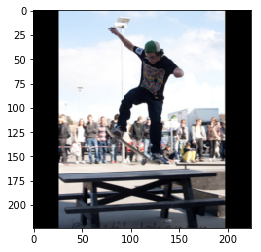

In [16]:
from PIL import Image

image_ids = coco.getImgIds()
print type(image_ids), len(image_ids)

rand_num = random.randint(0, len(image_ids))
# img_id = image_ids[rand_num]
img_id = image_ids[:5]

img_info = coco.loadImgs(img_id)[:5]
img_name = coco.loadImgs(img_id)[0]['file_name']
img_path = os.path.join(imageDir, img_name)
image = transforms(Image.open(img_path).convert('RGB'))

print 'img_id: ', img_id
# print 'img_info: ', img_info
# print 'img_name: ', img_name
print 'img_path: ', img_path
print 'img_type: ', type(image), image.size()
imshow2(image)

In [17]:
from PIL import Image

image_ids = coco.getImgIds()
print type(image_ids), len(image_ids)

def get_val_batch(batch_size=10, start_num=0):

    img_id = image_ids[start_num:start_num + batch_size]
#     print 'img_id: ', img_id
    img_all = []
    for i in range(len(img_id)):
        img_name = coco.loadImgs(img_id)[i]['file_name']
        img_path = os.path.join(imageDir, img_name)
        image = transforms(Image.open(img_path).convert('RGB'))
    #     print 'img_name: ', img_name
    #     print 'img_path: ', img_path
    #     print 'img_type: ', type(image), image.size()
    #     imshow2(image)

        img = image.unsqueeze(0)
    #     print 'img_size: ', img.size()
        img_all.append(img.numpy())

    img_batch = torch.from_numpy(np.vstack((x for x in img_all)))
#     print type(result), result.size()
    return img_batch, img_id

img_batch, img_id = get_val_batch(batch_size=10, start_num=0)
print type(img_batch), img_batch.size()
print type(img_id), img_id

<type 'list'> 40504
<class 'torch.FloatTensor'> torch.Size([10, 3, 224, 224])
<type 'list'> [262148, 393225, 393226, 109229, 131089, 262162, 393243, 262175, 131108, 393254]


In [18]:
import math
import time

def GetFeaturesInBatch(data, batch_size=10, isLSTM=True):
    features_all = []
    length_data = len(data)
    length = length_data if (length_data < batch_size) else batch_size
    imgs = Variable(data)
    features = extractor.forward(imgs)['fc'].squeeze()
    hidden_0 = features.unsqueeze(0)  
    if isLSTM:
        c_0 = hidden_0.clone()
        hidden_0 = (hidden_0, c_0)        
    return hidden_0

def record_val_caption(start=0, batch_size=10, end=30, print_every = 10):
    epochs = int(math.ceil((end + 0.0) / batch_size))
#     print epochs
    id_record = []
    caption_record = []
    start_time = time.time()
    for epoch in range(epochs):
        if epoch + 1 != epochs:
            img_batch, img_id = get_val_batch(batch_size=batch_size, start_num=epoch*batch_size)
        if epoch + 1 == epochs:
            img_batch, img_id = get_val_batch(batch_size=end-epoch*batch_size, start_num=epoch*batch_size)
        id_record.append(img_id)
        hidden_0 = GetFeaturesInBatch(img_batch, batch_size=batch_size, isLSTM=True)
        imageLen = hidden_0[0].size(1)

        seq_length = 17
        bsz = imageLen
        start_caption = Variable(torch.ones(1, bsz).long())
        hidden = hidden_0
        caption_in = start_caption

        output_all = []
        model.eval()
        for i in range(seq_length):
            output, hidden = model(caption_in, hidden)
            _, topi = output.data.topk(1)
            guess = topi.numpy().squeeze().T
            output_all.append(guess)
            caption_in = Variable(torch.from_numpy(guess).unsqueeze(0))

        guess_seq = np.vstack((x for x in output_all)).T
#         print guess_seq.shape

        for i in range(bsz):
            guess_str = decode_captions(guess_seq[i], mydict['idx_to_word'])
#             print guess_str
            caption_record.append(guess_str)
        #     img = img_batch[i] 
        #     imshow2(img)
        
        if epoch % print_every == 0 and epoch > 0:
            print 'epoch %d | process %3.2f%% | cost %ds' % (epoch, 100*(epoch+0.0)/epochs, time.time()-start_time )
        
    id_record = np.hstack((x for x in id_record))
    
    result = []
    for i in range(len(caption_record)):
        dic={}
        dic[u'image_id'] = id_record[i].item()
        dic[u'caption'] = caption_record[i]
        result.append(dic)

    return id_record, caption_record, result


In [19]:
id_record, caption_record, result = record_val_caption(start=0, batch_size=10, end=100, print_every=2)

epoch 2 | process 20.00% | cost 2s
epoch 4 | process 40.00% | cost 4s
epoch 6 | process 60.00% | cost 6s
epoch 8 | process 80.00% | cost 8s


a woman is sitting on a bench with a dog
img_id:  74
img_info:  [{u'license': 2, u'file_name': u'COCO_val2014_000000000074.jpg', u'coco_url': u'http://mscoco.org/images/74', u'height': 426, u'width': 640, u'date_captured': u'2013-11-15 03:08:44', u'flickr_url': u'http://farm5.staticflickr.com/4087/5078192399_aaefdb5074_z.jpg', u'id': 74}]
img_name:  COCO_val2014_000000000074.jpg


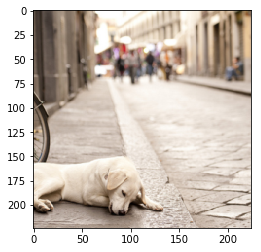

In [20]:
import random
def check_img_id(imgid):
    img_info = coco.loadImgs(imgid)
    img_name = coco.loadImgs(imgid)[0]['file_name']
    img_path = os.path.join(imageDir, img_name)
    image = transforms(Image.open(img_path).convert('RGB'))
    
    print 'img_id: ', imgid
    print 'img_info: ', img_info
    print 'img_name: ', img_name
#     print 'img_path: ', img_path
    imshow2(image)
    

rand_num = random.randint(0, len(result))
image_id = result[rand_num]['image_id']
caption = result[rand_num]['caption']

print caption
check_img_id(image_id)

## Save the id and caption in json file

In [21]:
save_val = False
if save_val:
    with open('./data/val/test500.json', 'w') as f:
        json.dump(result, f)
        
load_val = True
if load_val:
    with open('./data/val/test500_model35000.json', 'r') as f:
        data = json.load(f)

# data = result
print type(data), len(data)
print data[0].keys()

<type 'list'> 500
[u'image_id', u'caption']


image_id:  393840
Guess:  a herd of sheep grazing on a lush green field
img_http:  http://farm1.staticflickr.com/112/260958189_8fe849d2fe_z.jpg


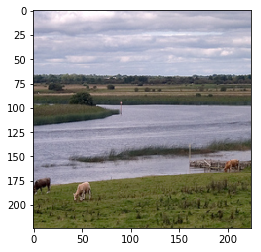

image_id:  262235
Guess:  a man in a suit brushing his teeth with a toothbrush
img_http:  http://farm1.staticflickr.com/15/21730223_66fc69407d_z.jpg


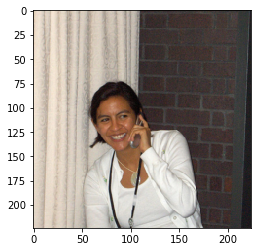

image_id:  394510
Guess:  a young boy is standing on a skateboard
img_http:  http://farm4.staticflickr.com/3195/2948181016_7cbbeeafab_z.jpg


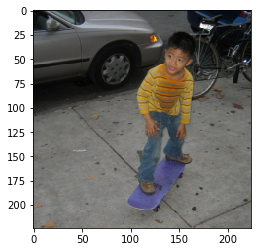

image_id:  262229
Guess:  a group of people playing frisbee in a field
img_http:  http://farm9.staticflickr.com/8310/7964956622_49225c5757_z.jpg


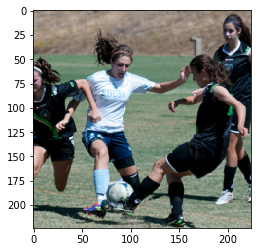

image_id:  263425
Guess:  a man riding a boat on a city street
img_http:  http://farm2.staticflickr.com/1266/4662377471_4d16b614a7_z.jpg


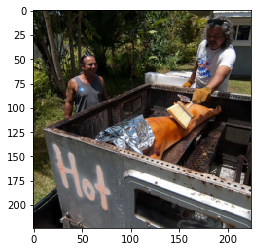

image_id:  262522
Guess:  a clock tower with a clock on the top
img_http:  http://farm5.staticflickr.com/4147/5008973851_861b3028e4_z.jpg


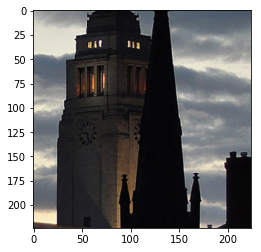

image_id:  263146
Guess:  a dog is sitting on a motorcycle with a helmet on it
img_http:  http://farm7.staticflickr.com/6136/5968372231_a8dcd01e2c_z.jpg


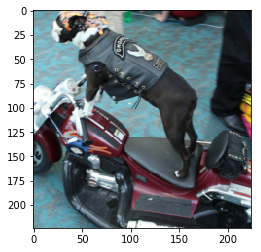

image_id:  263299
Guess:  a train is traveling down the tracks near a <unk>
img_http:  http://farm4.staticflickr.com/3211/2742574985_a2834f8947_z.jpg


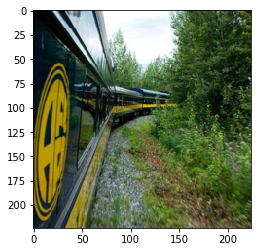

image_id:  836
Guess:  a person on a snowboard in the snow
img_http:  http://farm5.staticflickr.com/4057/4414624841_e9fa4a1c38_z.jpg


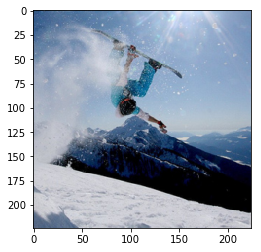

image_id:  131581
Guess:  a man riding a bike down a street next to a red train
img_http:  http://farm3.staticflickr.com/2759/4120691539_58188f933a_z.jpg


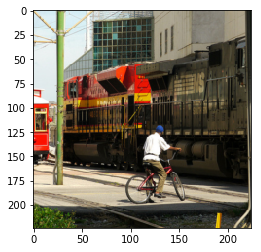

In [26]:
import random
def check_img_id(imgid):
    img_info = coco.loadImgs(imgid)
    img_name = coco.loadImgs(imgid)[0]['file_name']
    img_path = os.path.join(imageDir, img_name)
    image = transforms(Image.open(img_path).convert('RGB'))
    
#     print 'img_id: ', imgid
#     print 'img_info: ', img_info
    print 'img_http: ', img_info[0]['flickr_url']
#     print 'img_name: ', img_name
    imshow2(image)    


for i in range(10):
    rand_num = random.randint(0, len(data))
#     print 'rand_num: ', rand_num
    print 'image_id: ', data[rand_num]['image_id']
    print 'Guess: ', data[rand_num]['caption']
    check_img_id(data[rand_num]['image_id'])


## evaluate with API

In [28]:
load_val = True
if load_val:
    with open('./data/val/test500_model35000.json', 'r') as f:
        data = json.load(f)

print type(data), len(data)
print data[0].keys()

<type 'list'> 500
[u'image_id', u'caption']


## Random Test

In [30]:
# import random
# def check_img_id(imgid):
#     img_info = coco.loadImgs(imgid)
#     img_name = coco.loadImgs(imgid)[0]['file_name']
#     img_path = os.path.join(imageDir, img_name)
#     image = transforms(Image.open(img_path).convert('RGB'))
    
#     print 'img_id: ', imgid
# #     print 'img_info: ', img_info
#     print 'img_name: ', img_name
# #     print 'img_path: ', img_path
#     imshow2(image)

    
    
# print type(id_record), id_record.shape
# # print id_record
# print type(caption_record), len(caption_record)

# for i in range(4):
#     rand_num = random.randint(0, len(id_record))
#     print type(caption_record[rand_num]), caption_record[rand_num]
#     # print type(id_record[22]), id_record[22]
#     check_img_id(id_record[rand_num].item())

## Test by the val data

<class 'torch.FloatTensor'> torch.Size([3, 224, 224])
A group of business people standing next to a large poster board.
A group of businessmen and women posing for a picture. 
a group of people in business attire are standing near a sign
The group of people in business suits is standing beside a large poster.
A group of people stand beside a building sign.


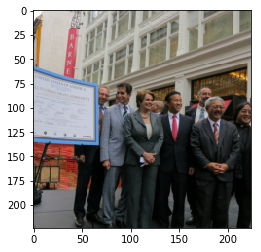

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img, targets):
    for i in range(len(targets)):
        print targets[i]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    plt.imshow(img)
  
  

rand_num = random.randint(0, len(cap))
img, targets = cap[rand_num]
print type(img), img.size()
imshow(img, targets)
plt.show()

(5, 17)
a man riding a motorcycle on a dirt road


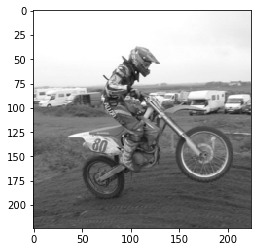

a plane is parked on the runway with a sky background


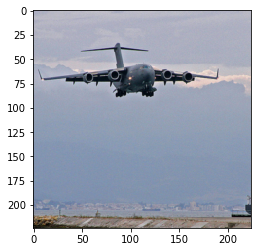

a group of people sitting around a table with a laptop


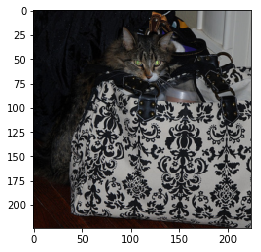

a group of giraffes are standing in a field


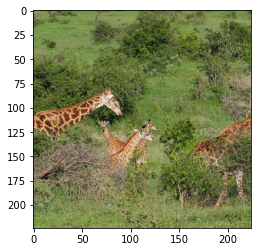

a sheep standing in a field with a mountain in the background


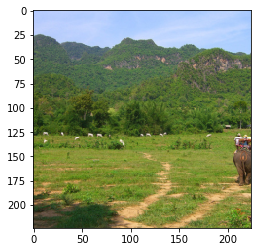

In [32]:
bsz = 5
_, _, hidden_0, masks_o, _ = GetBatchData(features_all, captions_all, bsz = bsz, isLSTM=True)

start_caption = Variable(torch.ones(1, bsz).long())
seq_length = 17

hidden = hidden_0
caption_in = start_caption
# print type(caption_in), caption_in.size()

output_all = []
model.eval()
for i in range(seq_length):
    output, hidden = model(caption_in, hidden)
    _, topi = output.data.topk(1)
    guess = topi.numpy().squeeze().T
    output_all.append(guess)
    caption_in = Variable(torch.from_numpy(guess).unsqueeze(0))

guess_seq = np.vstack((x for x in output_all)).T
print guess_seq.shape

for i in range(bsz):
    guess_str = decode_captions(guess_seq[i], mydict['idx_to_word'])
    print guess_str
    img, _ = cap[(masks_o/5)[i]]
    imshow2(img)
    plt.show()    


## Test with my own picture

In [33]:
import os
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

data_transforms = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = './mypic'
dset = datasets.ImageFolder(data_dir, data_transforms)
dset_loader = DataLoader(dset, batch_size = 5, num_workers=1)

dset_size = len(dset)
print dset_size
dset_classes = dset.classes

4


In [34]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    plt.imshow(inp)
    
inputs, classes = next(iter(dset_loader))


#check for the image and input data size
print type(inputs)
print inputs.size()

def GetFeaturesInBatch(data, batch_size=5, isLSTM=True):
    ##TODO, get the img features in batches
    features_all = []
    length_data = len(data)
    length = length_data if (length_data < batch_size) else batch_size
    imgs = Variable(data)
    features = extractor.forward(imgs)['fc'].squeeze()
    hidden_0 = features.unsqueeze(0)
    
    if isLSTM:
        c_0 = hidden_0.clone()
        hidden_0 = (hidden_0, c_0)
        
    return hidden_0
    

<class 'torch.FloatTensor'>
torch.Size([4, 3, 224, 224])


4
(4, 17)
a laptop computer sitting on top of a table


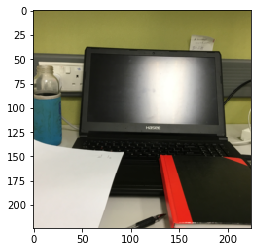

a group of people riding horses down a street


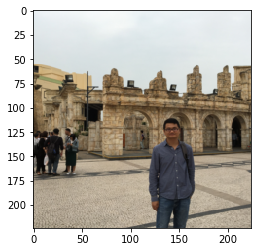

a man is playing tennis on a tennis court


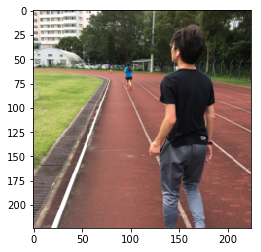

a cat sitting on a chair in a chair


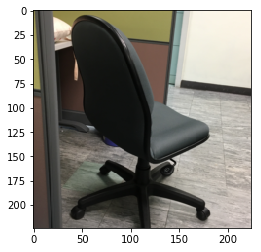

In [35]:
hidden_0 = GetFeaturesInBatch(inputs, batch_size=5)
imageLen = hidden_0[0].size(1)


seq_length = 17
bsz = imageLen if imageLen < 5 else 5
print bsz
start_caption = Variable(torch.ones(1, bsz).long())
hidden = hidden_0
caption_in = start_caption

output_all = []
model.eval()
for i in range(seq_length):
    output, hidden = model(caption_in, hidden)
    _, topi = output.data.topk(1)
    guess = topi.numpy().squeeze().T
    output_all.append(guess)
    caption_in = Variable(torch.from_numpy(guess).unsqueeze(0))

guess_seq = np.vstack((x for x in output_all)).T
print guess_seq.shape

for i in range(bsz):
    guess_str = decode_captions(guess_seq[i], mydict['idx_to_word'])
    print guess_str
    ##TODO, transfer the img information to draw it 
    img = inputs[i] 
    imshow(img)
    plt.show() 

## Draw the Loss curve

In [13]:
import h5py, os
import numpy as np

LoadFlag = True
if LoadFlag:
    h5f = h5py.File('./loss/loss_5000.h5','r')
    loss_5000 = h5f['dataset_1'][:]
    h5f.close()
    h5f = h5py.File('./loss/loss_8000.h5','r')
    loss_8000 = h5f['dataset_1'][:]
    h5f.close()  
    h5f = h5py.File('./loss/loss_15000.h5','r')
    loss_15000 = h5f['dataset_1'][:]
    h5f.close() 
    h5f = h5py.File('./loss/loss_20000.h5','r')
    loss_20000 = h5f['dataset_1'][:]
    h5f.close() 
    h5f = h5py.File('./loss/loss_25000.h5','r')
    loss_25000 = h5f['dataset_1'][:]
    h5f.close() 
    
print type(loss_5000), loss_5000.shape
print type(loss_8000), loss_8000.shape

loss = np.hstack((loss_5000, loss_8000, loss_15000, loss_20000, loss_25000))
print type(loss), loss.shape

<type 'numpy.ndarray'> (99,)
<type 'numpy.ndarray'> (59,)
<type 'numpy.ndarray'> (495,)


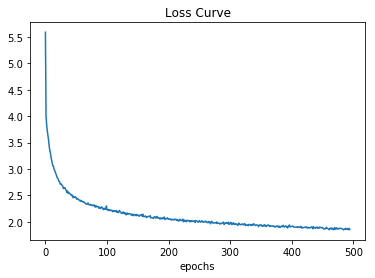

In [18]:

import matplotlib.pyplot as plt
img = plt.plot(loss)
plt.title('Loss Curve')
plt.xlabel('epochs')
plt.show()

In [22]:
file = open('/home/xuxin/Desktop/testdata.txt', 'w')
x = loss
for i in range(len(x)):

    txt = str(x[i]) + '\n'

    file.write(txt)

file.close()